In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
import optuna
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import gpytorch
import mrmr

In [8]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [9]:
df =df.drop(columns = ['TAU_bl','PTAU_bl', 'ABETA_bl', 'PTEDUCAT'])

df.head()

,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,7.0,2.0,-1.036305,-0.944252,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,8.0,4.0,1.193040,1.119475,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,1.0,5.0,1.485349,1.479118,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,6.0,8.0,-0.076402,-0.117696,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,0.5,0.040211,18.0,1.883734,1.336483,0.512023,5.0,1.0,-0.176979,-0.460626,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


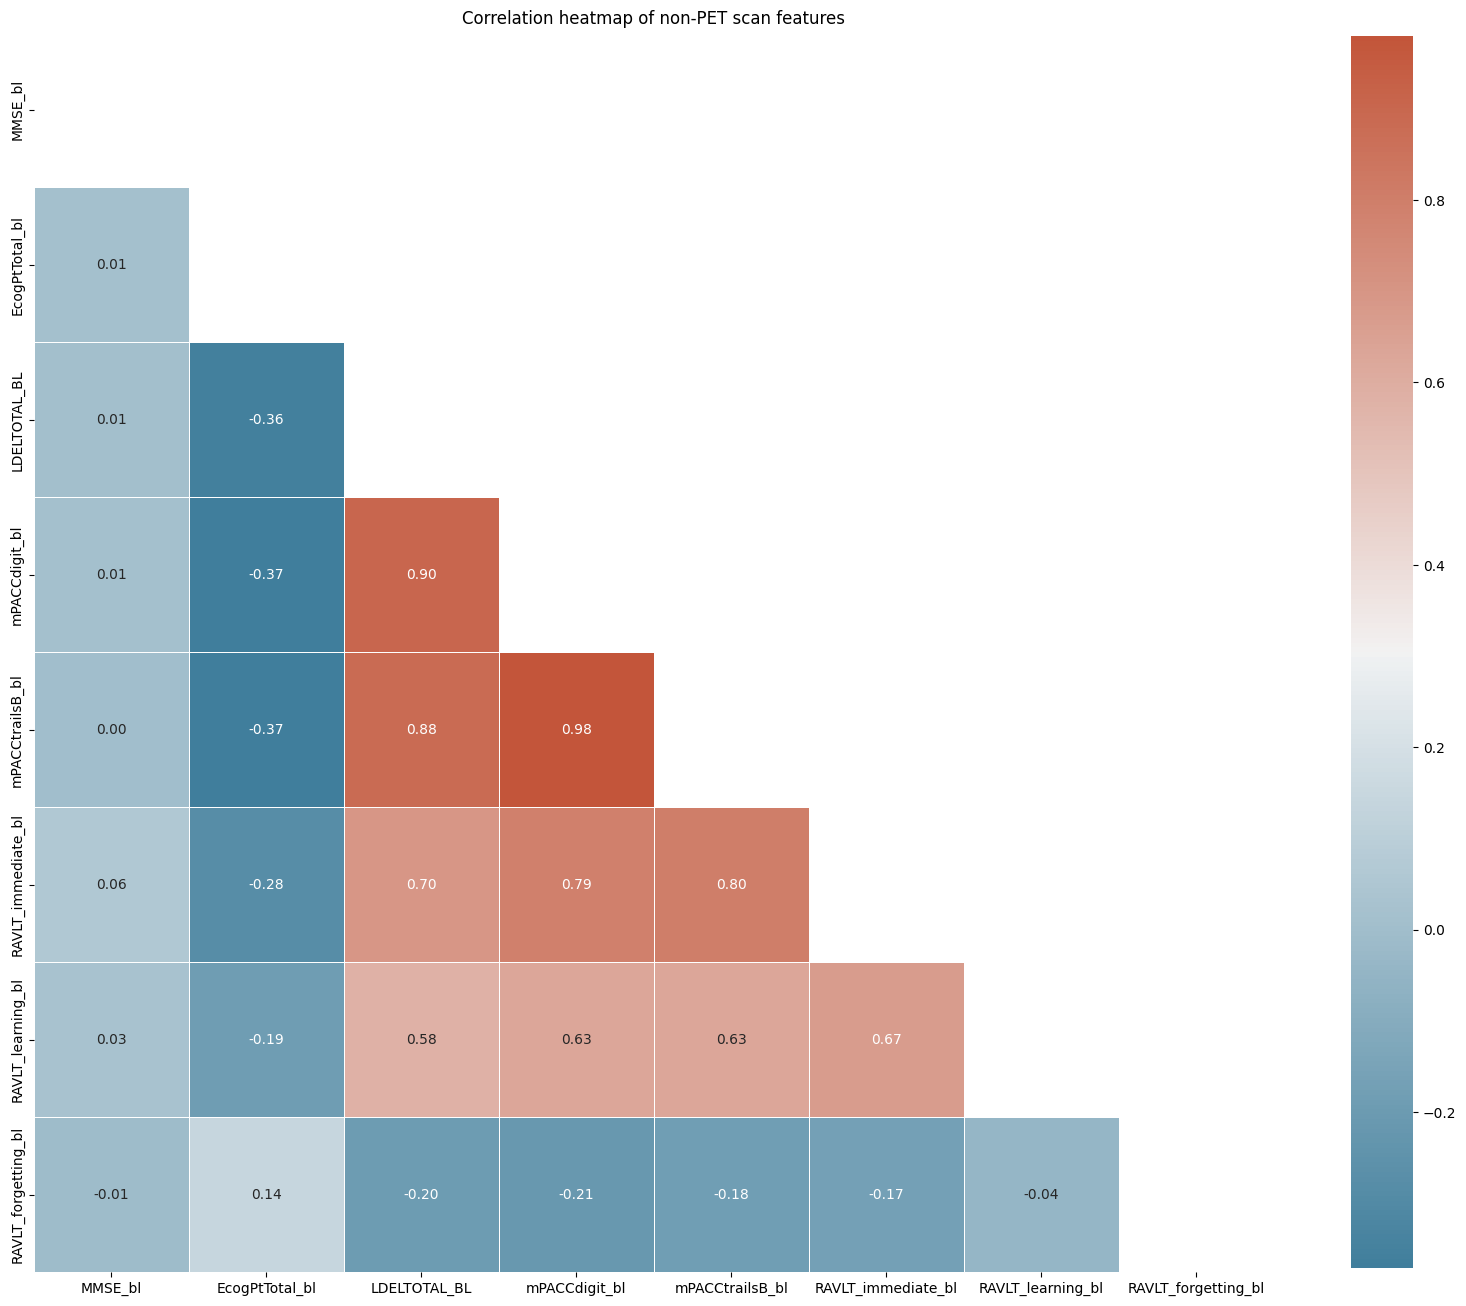

In [39]:
df_corr = df.filter(['MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])


plotting_matrix = df_corr.corr()


# Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(plotting_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(plotting_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation heatmap of non-PET scan features')
plt.show()

In [ ]:
df_mmse = df.drop(columns = ['EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_ecog = df.drop(columns = ['MMSE_bl',	'LDELTOTAL_BL',	'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_ldel = df.drop(columns = ['MMSE_bl',	'EcogPtTotal_bl',	'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_mpacc_digit = df.drop(columns = ['MMSE_bl', 'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_mpacc_trails = df.drop(columns = ['MMSE_bl', 'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_ravlt_imm = df.drop(columns = ['MMSE_bl', 'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl'])
df_ravlt_learn = df.drop(columns = ['MMSE_bl', 'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_forgetting_bl'])
df_ravlt_forget = df.drop(columns = ['MMSE_bl', 'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl'])


In [18]:
df_ravlt_forget.head()

,RAVLT_forgetting_bl,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,2.0,-1.036305,-0.944252,-0.943637,-0.956548,0.039320,0.038841,0.011054,0.014155,-1.536236,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,4.0,1.193040,1.119475,1.146182,0.929328,0.057261,0.053242,0.013008,0.017184,1.734375,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,5.0,1.485349,1.479118,1.520871,1.377067,0.054272,0.053113,0.013620,0.016730,1.583530,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,8.0,-0.076402,-0.117696,-0.401966,-0.095506,0.044834,0.042373,0.011938,0.015462,-0.681419,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,1.0,-0.176979,-0.460626,-0.096761,-0.212546,0.042674,0.039067,0.011457,0.013684,-0.176115,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [ ]:
X = df_ravlt_imm.drop(columns=['RAVLT_immediate_bl'])
y = df_ravlt_imm.filter(['RAVLT_immediate_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

In [ ]:
X = df_ravlt_learn.drop(columns=['RAVLT_learning_bl'])
y = df_ravlt_learn.filter(['RAVLT_learning_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

100%|██████████| 50/50 [00:01<00:00, 29.96it/s]


In [ ]:
X = df_ravlt_forget.drop(columns=['RAVLT_forgetting_bl'])
y = df_ravlt_forget.filter(['RAVLT_forgetting_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

['SUVr_Fusiform_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Pallidum_R.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Cerebellum_8_L.nii',
 'SUVr_Pallidum_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_Lingual_R.nii']

In [34]:
X = df_mmse.drop(columns=['MMSE_bl'])
y = df_mmse.filter(['MMSE_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

100%|██████████| 50/50 [00:01<00:00, 46.97it/s]


['SUVr_Vermis_9.nii',
 'SUVr_Temporal_Pole_Sup_L.nii',
 'SUVr_Cerebellum_10_L.nii',
 'SUVr_Cerebellum_7b_L.nii',
 'SUVr_Vermis_4_5.nii',
 'SUVr_OFClat_L.nii',
 'SUVr_Thal_MDl_L.nii',
 'SUVr_Cerebellum_8_L.nii',
 'SUVr_Caudate_R.nii',
 'SUVr_Paracentral_Lobule_L.nii']

In [36]:
X = df_ldel.drop(columns=['LDELTOTAL_BL'])
y = df_ldel.filter(['LDELTOTAL_BL'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

100%|██████████| 50/50 [00:01<00:00, 45.99it/s]


['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Temporal_Inf_L.nii',
 'SUVr_Pallidum_R.nii',
 'SUVr_Angular_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Pallidum_L.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Parietal_Sup_L.nii']

In [37]:
X = df_mpacc_digit.drop(columns=['mPACCdigit_bl'])
y = df_mpacc_digit.filter(['mPACCdigit_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

100%|██████████| 50/50 [00:01<00:00, 45.75it/s]


['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Temporal_Inf_L.nii',
 'SUVr_Pallidum_R.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_Pallidum_L.nii',
 'SUVr_Angular_L.nii',
 'SUVr_Fusiform_R.nii']

In [38]:
X = df_mpacc_trails.drop(columns=['mPACCtrailsB_bl'])
y = df_mpacc_trails.filter(['mPACCtrailsB_bl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
features = mrmr.mrmr_regression(X, y, K= 50)
features[:10]

100%|██████████| 50/50 [00:01<00:00, 42.48it/s]


['SUVr_Precuneus_L.nii',
 'SUVr_Thal_AV_R.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Temporal_Inf_L.nii',
 'SUVr_Thal_AV_L.nii',
 'SUVr_Lingual_L.nii',
 'SUVr_Pallidum_R.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Angular_L.nii']